In [1]:
import os
os.chdir('/home/jknize/main/repo/CSC578/detectron2')

Simple ResNet object detection evaluation using pre-trained backbone

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_val_dataset", {}, "../datasets/coco/annotations/filtered_instances_val2017.json", "../datasets/coco/val2017")
register_coco_instances("full_train_dataset2", {}, "../datasets/coco/annotations/instances_train2017.json", "../datasets/coco/train2017")
# register_coco_instances("full_val_dataset", {}, "../datasets/coco/annotations/instances_val2017.json", "../datasets/coco/val2017")


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



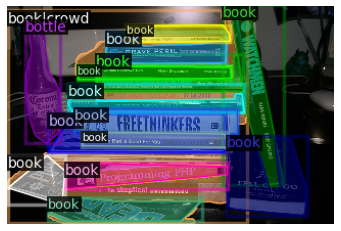

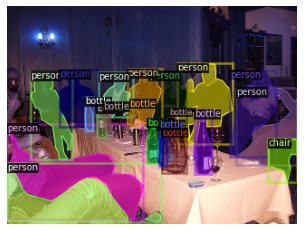

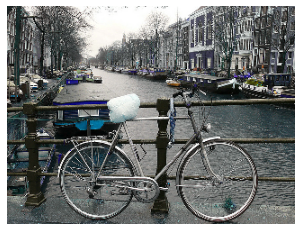

In [3]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import random
import cv2
import matplotlib.pyplot as plt

my_dataset_metadata = MetadataCatalog.get("my_val_dataset")# .set(thing_classes=["person", "dog", "bottle", "chair", "book"])
dataset_dicts = DatasetCatalog.get("my_val_dataset")

# Visualize 3 random images
for d in random.sample(dataset_dicts, 3):
    file_name = d['file_name']
    img = cv2.imread(d["file_name"]) 
    if img is None:
        print(f"Failed to load image: {d['file_name']}")
        continue 
     
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)  # Draw annotations on the image
    output_image = out.get_image()[:, :, ::-1]  # Convert back from BGR to RGB for matplotlib
    plt.imshow(output_image)
    plt.axis("off")  # Turn off axis
    plt.show()

In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# load simple ResNet-50 model without FPN
cfg = get_cfg()
cfg.merge_from_file("configs/COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")
# use COCO-pretrained detection weights for quick evaluation
cfg.MODEL.WEIGHTS = "../../../model_final_721ade.pkl" # downloaded from detectron2 MODEL_ZOO.md
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 

cfg.DATASETS.TRAIN = ("full_train_dataset2",)
cfg.DATASETS.TEST = ("my_val_dataset",)
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5

predictor = DefaultPredictor(cfg)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
evaluator = COCOEvaluator("my_val_dataset", cfg, False, output_dir="./knize/output/subset")
results = trainer.test(cfg, model=trainer.model, evaluators=[evaluator])
print("Evaluation Results:")
for key, value in results.items():
    print(f"{key}: {value}")

# when only change is filtered_annotations, predictions are made on dataset not within subset classes -> error



[11/10 07:36:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

/home/jknize/.local/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/10 07:37:13 d2.evaluation.evaluator]: Inference done 11/5000. Dataloading: 0.0009 s/iter. Inference: 0.1470 s/iter. Eval: 0.0003 s/iter. Total: 0.1482 s/iter. ETA=0:12:19
[11/10 07:37:18 d2.evaluation.evaluator]: Inference done 60/5000. Dataloading: 0.0014 s/iter. Inference: 0.1055 s/iter. Eval: 0.0003 s/iter. Total: 0.1073 s/iter. ETA=0:08:49
[11/10 07:37:23 d2.evaluation.evaluator]: Inference done 114/5000. Dataloading: 0.0014 s/iter. Inference: 0.0988 s/iter. Eval: 0.0003 s/iter. Total: 0.1006 s/iter. ETA=0:08:11
[11/10 07:37:28 d2.evaluation.evaluator]: Inference done 166/5000. Dataloading: 0.0014 s/iter. Inference: 0.0977 s/iter. Eval: 0.0003 s/iter. Total: 0.0995 s/iter. ETA=0:08:00
[11/10 07:37:33 d2.evaluation.evaluator]: Inference done 217/5000. Dataloading: 0.0014 s/iter. Inference: 0.0975 s/iter. Eval: 0.0003 s/iter. Total: 0.0993 s/iter. ETA=0:07:54
[11/10 07:37:38 d2.evaluation.evaluator]: Inference done 269/5000. Dataloading: 0.0014 s/iter. Inference: 0.0970 s/iter. E

AssertionError: A prediction has class=56, but the dataset only has 5 classes and predicted class id should be in [0, 4].